In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import fraud_detection.data.ip_geolocation as ip
from fraud_detection.data.loader import DataHandler
from fraud_detection.core.settings import settings
from fraud_detection.data.cleaning import DataCleaning
from fraud_detection.viz.plots import Visualizer
from fraud_detection.features.pipeline import build_feature_pipeline
from imblearn.over_sampling import SMOTE

- Data I/O

In [2]:
# Card data 
credit_df = DataHandler.from_registry("DATA", "raw_dir", "creditcard.csv").load()

# Fraud Data
fraud_df = DataHandler.from_registry(
    "DATA", "raw_dir", "Fraud_Data.csv").load()

# geo data
ip_df = DataHandler.from_registry(
    "DATA", "raw_dir", "IpAddress_to_Country.csv").load()

In [3]:
credit_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [4]:
# Columns in Fraud_Data.csv
datetime_cols = ["signup_time", "purchase_time"]
numeric_cols = ["purchase_value", "age"]
protected_cols = ["user_id", "device_id", "ip_address"]  # do not strip

In [5]:
cleaner = DataCleaning(
    drop_duplicates=True,              # remove exact duplicate rows
    duplicate_subset=["user_id", "purchase_time",
                      "purchase_value"],  # business-safe keys
    strip_strings=True,                # strip text columns
    protected_string_columns=protected_cols,
    empty_string_as_nan=True,
    datetime_columns=datetime_cols,
    numeric_columns=numeric_cols,
    verbose=True
)

In [6]:
cleaned_df = cleaner.clean(fraud_df)
print(f"Cleaned shape: {cleaned_df.shape}")

Starting data cleaning | rows=151112
Stripped whitespace from 5 string columns.
Removed 0 duplicate rows.
Finished data cleaning | rows=151112

Cleaned shape: (151112, 11)


In [7]:
# 1. Clean reference table
ip_country_df = ip.clean_ip_country_table(ip_df)

# 2. Normalize transaction IPs

fraud_df = ip.normalize_ip_column(fraud_df, ip_col="ip_address")

# 3. Map IPs to countries
df = ip.map_ip_to_country(cleaned_df, ip_country_df)

[IP TABLE CLEAN] 0 invalid rows removed, final size 138846
[IP NORMALIZATION] Removed 0 invalid IP rows
[IP MERGE] Country coverage: 85.46%


In [8]:
df

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States
...,...,...,...,...,...,...,...,...,...,...,...,...
151107,345170,2015-01-27 03:03:34,2015-03-29 00:30:47,43,XPSKTWGPWINLR,SEO,Chrome,M,28,3.451155e+09,1,United States
151108,274471,2015-05-15 17:43:29,2015-05-26 12:24:39,35,LYSFABUCPCGBA,SEO,Safari,M,32,2.439047e+09,0,Netherlands
151109,368416,2015-03-03 23:07:31,2015-05-20 07:07:47,40,MEQHCSJUBRBFE,SEO,IE,F,26,2.748471e+09,0,Japan
151110,207709,2015-07-09 20:06:07,2015-09-07 09:34:46,46,CMCXFGRHYSTVJ,SEO,Chrome,M,37,3.601175e+09,0,United States


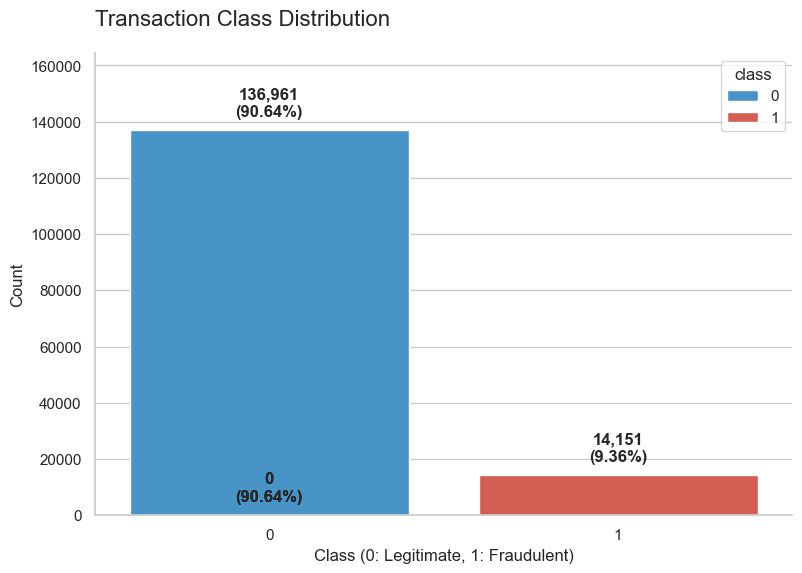

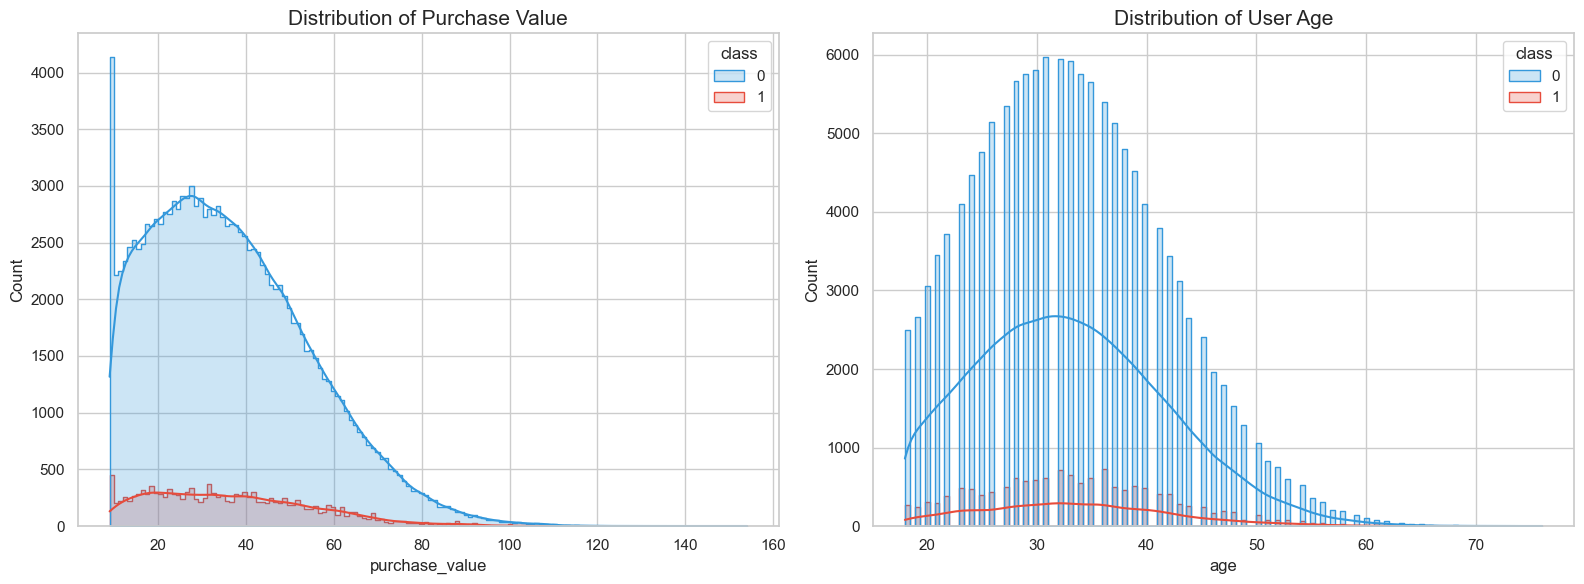

D:\10Acadamy\Week 5&6\Tasks\fraud-detection\src\fraud_detection\viz\plots.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


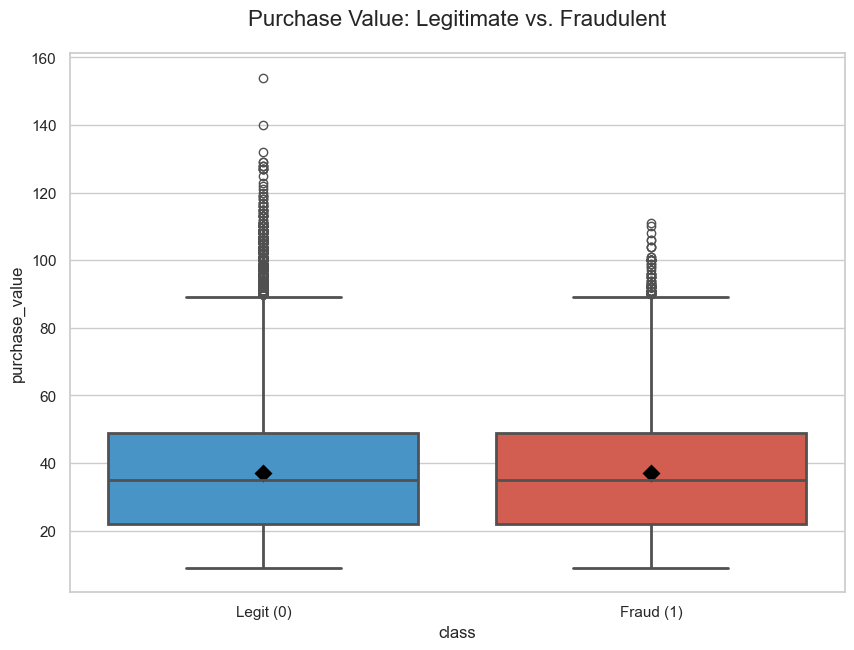

In [9]:
viz = Visualizer()
# 1. Check Class Imbalance
viz.analyze_class_distribution(df)


# 2. Compare Numerical Distributions (Age and Purchase Value)
viz.plot_fraud_distributions(df)

# 3. Deep dive into Purchase Value Outliers
viz.plot_purchase_value_boxplot(df)

In [10]:
FEATURES = settings.get("features")

TARGET = FEATURES["target"]
NUM_COLS = FEATURES["numeric"]
CAT_COLS = FEATURES["categorical"]

In [11]:
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [12]:
feature_pipeline = build_feature_pipeline(NUM_COLS, CAT_COLS)

X_train_transformed = feature_pipeline.fit_transform(X_train)
X_test_transformed = feature_pipeline.transform(X_test)


In [13]:
feature_pipeline

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('custom_features', ...), ('preprocessing', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different tran

In [14]:
# Ensure SMOTE is available
smote = SMOTE(random_state=42)

# Apply SMOTE on training data only
X_train_resampled, y_train_resampled = smote.fit_resample(
    X_train_transformed, y_train)


print("\n--- Class Distribution AFTER SMOTE ---")
print(y_train_resampled.value_counts(normalize=True).map("{:.2%}".format))


--- Class Distribution AFTER SMOTE ---
class
0    50.00%
1    50.00%
Name: proportion, dtype: object


D:\10Acadamy\Week 5&6\Tasks\fraud-detection\src\fraud_detection\viz\plots.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


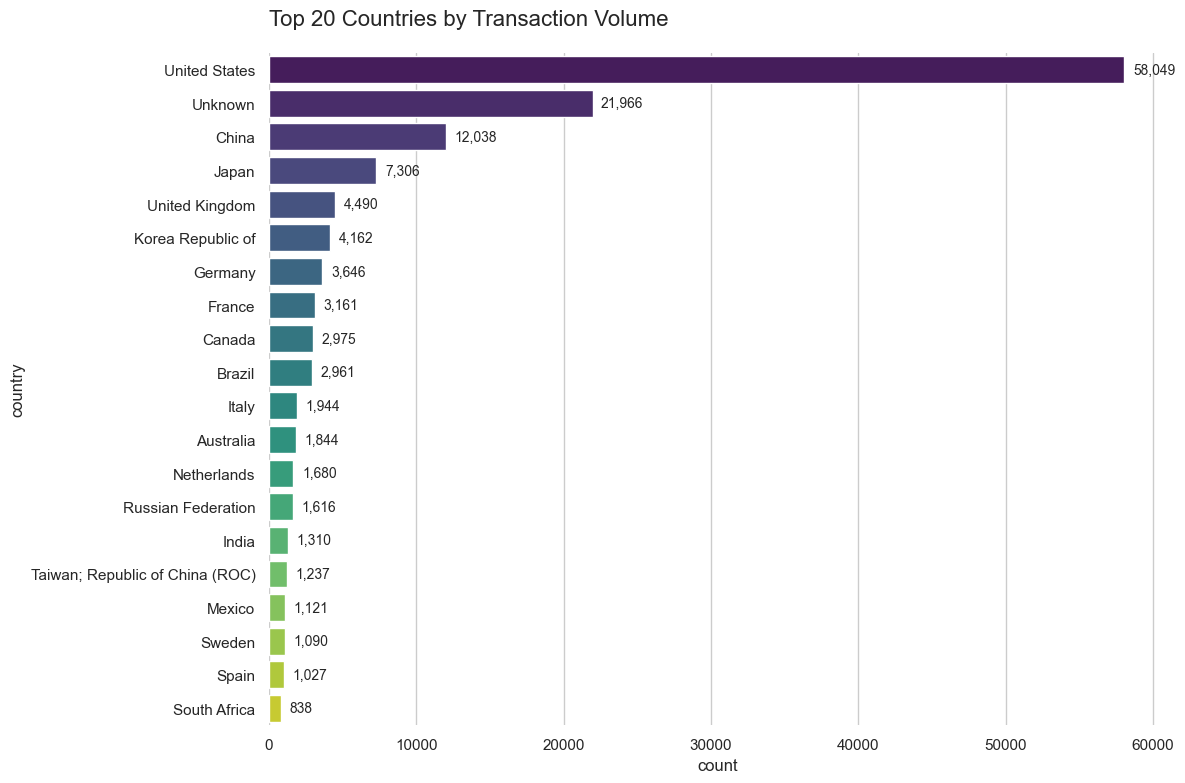

D:\10Acadamy\Week 5&6\Tasks\fraud-detection\src\fraud_detection\viz\plots.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


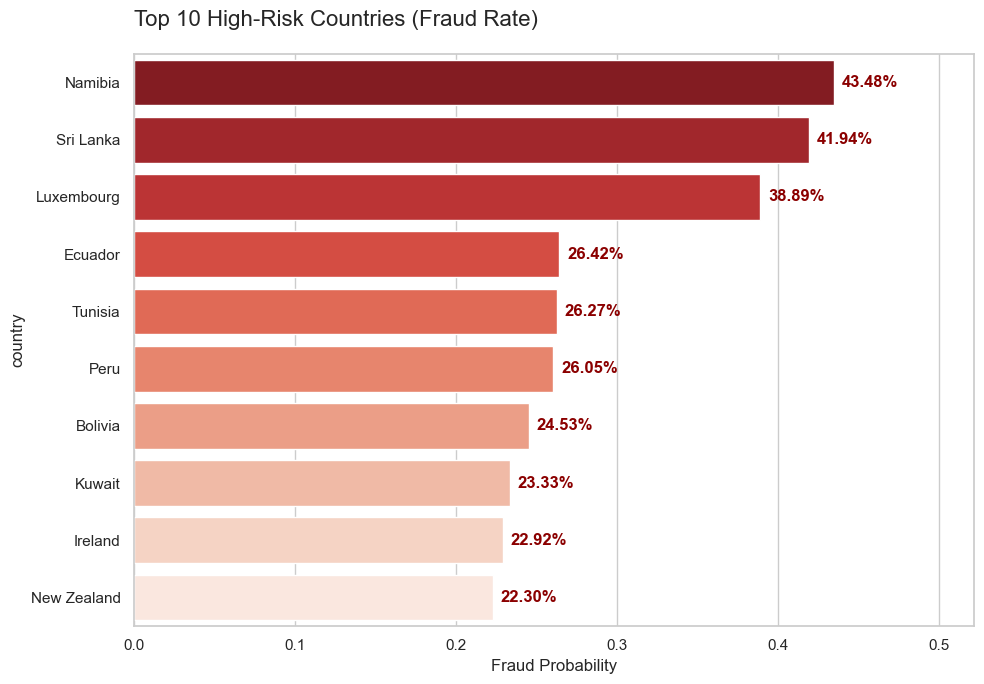

In [16]:
# 4. Geographic Analysis (Volume vs Risk)
viz.plot_top_countries(df)
viz.plot_fraud_rate_by_country(df)

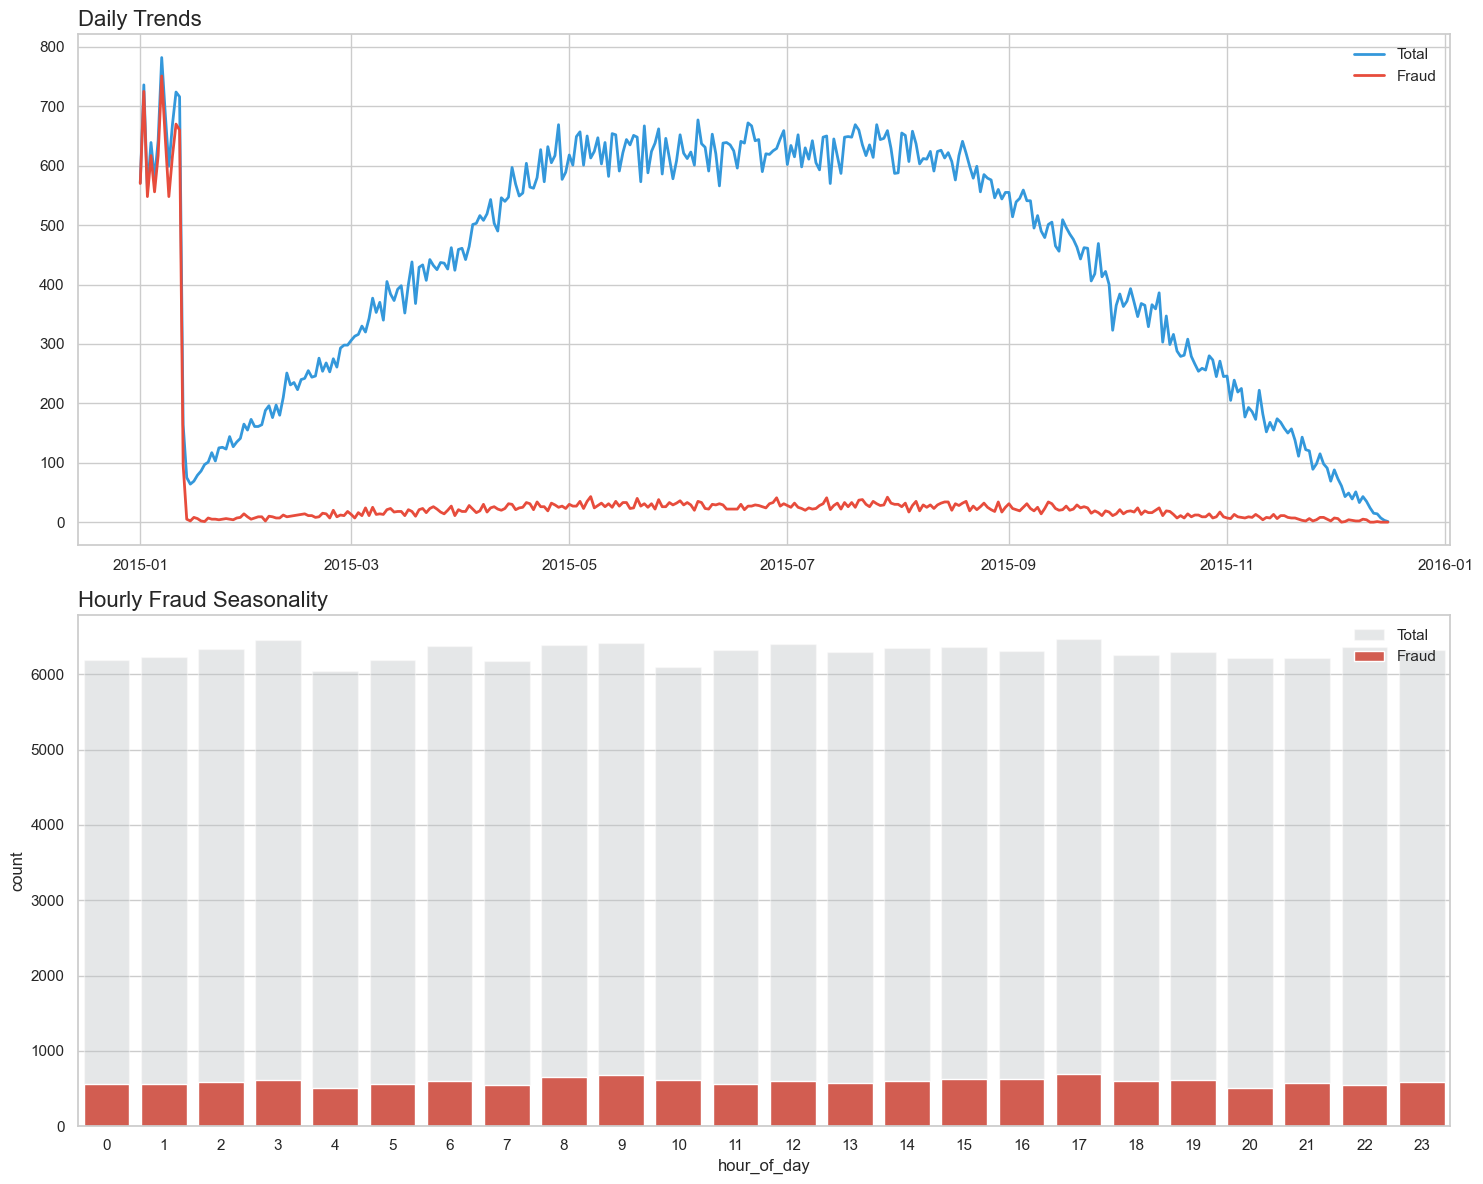

In [17]:
# 5. Temporal Analysis (When does fraud happen?)
viz.plot_time_series(df)

### Feature Engineering and Sampling Imbalanced data

In [18]:
# -----------------------------
# 1. Split features and target
# -----------------------------
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -----------------------------
# 2. Build and apply feature pipeline
# -----------------------------
feature_pipeline = build_feature_pipeline(NUM_COLS, CAT_COLS)

X_train_transformed = feature_pipeline.fit_transform(X_train)
X_test_transformed = feature_pipeline.transform(X_test)

In [19]:
# -----------------------------
# 3. Save BEFORE SMOTE
# -----------------------------
transformers = feature_pipeline.named_steps['preprocessing'].transformers_
num_cols = transformers[0][2]
cat_cols = transformers[1][1].named_steps['encoder'].get_feature_names_out(
    CAT_COLS)
feature_names = list(num_cols) + list(cat_cols)

train_original_df = pd.DataFrame(X_train_transformed, columns=feature_names)
train_original_df[TARGET] = y_train.reset_index(drop=True)

train_original_handler = DataHandler.from_registry(
    section="DATA",
    path_key="processed_dir",
    filename="train_original.parquet"
)
train_original_handler.save(train_original_df)

# Test set
test_df = pd.DataFrame(X_test_transformed, columns=feature_names)
test_df[TARGET] = y_test.reset_index(drop=True)

test_handler = DataHandler.from_registry(
    section="DATA",
    path_key="processed_dir",
    filename="test_original.parquet"
)
test_handler.save(test_df)

print("\n--- Pre-SMOTE data saved ---")
print("--- Class Distribution BEFORE SMOTE ---")
print(y_train.value_counts(normalize=True).map("{:.2%}".format))



--- Pre-SMOTE data saved ---
--- Class Distribution BEFORE SMOTE ---
class
0    90.64%
1     9.36%
Name: proportion, dtype: object


In [20]:
# -----------------------------
# 4. Apply SMOTE to training data
# -----------------------------
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(
    X_train_transformed, y_train)

# -----------------------------
# 5. Save AFTER SMOTE
# -----------------------------
train_resampled_df = pd.DataFrame(X_train_resampled, columns=feature_names)
train_resampled_df[TARGET] = y_train_resampled.reset_index(drop=True)

train_resampled_handler = DataHandler.from_registry(
    section="DATA",
    path_key="processed_dir",
    filename="train_resampled.parquet"
)
train_resampled_handler.save(train_resampled_df)

print("\n--- Post-SMOTE data saved ---")
print("--- Class Distribution AFTER SMOTE ---")
print(y_train_resampled.value_counts(normalize=True).map("{:.2%}".format))


--- Post-SMOTE data saved ---
--- Class Distribution AFTER SMOTE ---
class
0    50.00%
1    50.00%
Name: proportion, dtype: object
